In [1]:
#imports
import tensorflow as tf
import numpy as np
import time
from scipy.stats import qmc


import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["font.size"] = 12
mpl.rcParams["text.usetex"] = True


In [2]:
tf.keras.backend.set_floatx("float32")

In [244]:
dim = 3
n_bc = dim * 2
n_data_per_bc = 8

engine = qmc.LatinHypercube(d=1)
data = np.zeros([n_bc, n_data_per_bc, dim+1])

for i, j in zip(range(n_bc), [+1, -1]*n_bc):
    
    if i % 2 == 0:
        for dd in range(dim):
            if i // 2 == dd:
                data[i,:, dd] = j
            else:
                data[i,:, dd] = (engine.random(n=n_data_per_bc)[:, 0] - 0.5) * 2
    elif i % 2 == 1:
        for dd in range(dim):
            if i // 2 == dd:
                data[i,:, dd] = j
            else:
                data[i,:, dd] = (engine.random(n=n_data_per_bc)[:, 0] - 0.5) * 2

for i in range(1,n_bc):
    data[i,:,dim] = 1.

In [245]:
data = data.reshape(n_data_per_bc*n_bc, dim+1)

In [246]:
x_d, y_d, z_d, t_d = map(lambda x: np.expand_dims(x, axis=1), 
                    [data[:, 0], data[:, 1], data[:, 2], data[:, 3]])

In [247]:
# 
N_c = 10000
engine = qmc.LatinHypercube(d=3)
colloc = engine.random(n=N_c)
colloc = 2 * (colloc -0.5)

In [248]:
x_c, y_c, z_c = map(lambda x: np.expand_dims(x, axis=1), 
               [colloc[:, 0], colloc[:, 1], colloc[:, 2]])




In [249]:
# Transform to float32
x_c, y_c, z_c, x_d, y_d, z_d, t_d =map(lambda x: tf.convert_to_tensor(x,dtype=tf.float32),
                             [x_c, y_c, z_c, x_d, y_d, z_d, t_d])

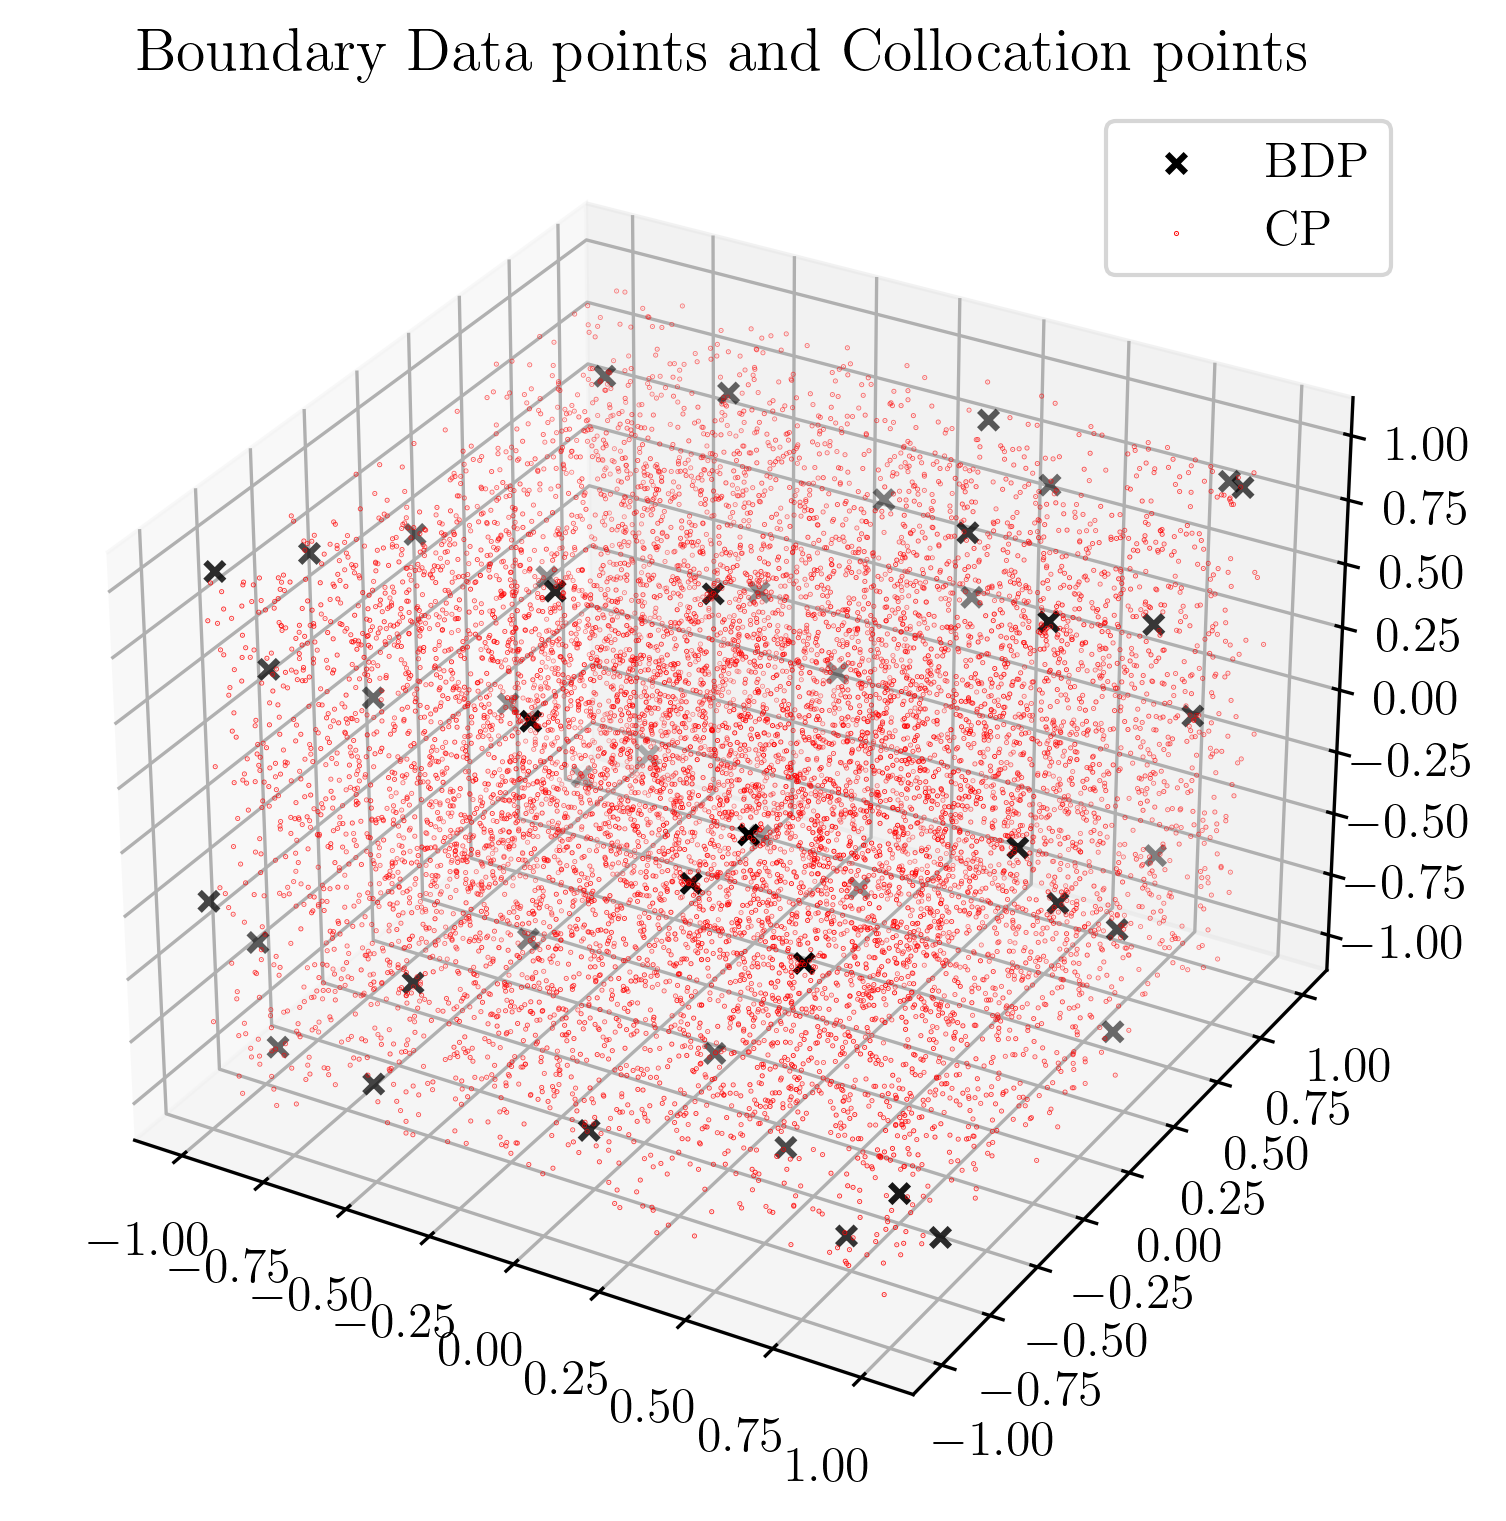

In [254]:
fig = plt.figure("", figsize=(6, 6), dpi=300)
ax = fig.add_subplot(111, projection='3d')

# 设置标题
ax.set_title("Boundary Data points and Collocation points")

# 绘制散点图
ax.scatter(x_d, y_d, z_d, marker='x', c='k', label='BDP')
ax.scatter(x_c, y_c, z_c, s=.2, marker=".", c="r", label="CP")

# 显示图形
plt.legend()
plt.savefig(f"/Users/michaellea/001 - M.Sc_HPC/55640-Project/Seminar-2/Presentation/Slides/F0PINN_DATA.png", bbox_inches='tight')
plt.show()

In [166]:
# 
### model builder function
def DNN_builder(in_shape=2, out_shape=1, n_hidden_layers=10, 
                neuron_per_layer=20, actfn="tanh"):
    # input layer
    input_layer = tf.keras.layers.Input(shape=(in_shape,))
    # hidden layers
    hidden = [tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)]
    for i in range(n_hidden_layers-1):
        new_layer = tf.keras.layers.Dense(neuron_per_layer,
                                          activation=actfn,
                                          activity_regularizer=None)(hidden[-1])
        hidden.append(new_layer)
    # output layer
    output_layer = tf.keras.layers.Dense(1, activation=None)(hidden[-1])
    # building the model
    name = f"DNN-{n_hidden_layers}"
    model = tf.keras.Model(input_layer, output_layer, name=name)
    return model

In [167]:
import os

In [228]:
#

layers = [1, 4, 8]
loss_dict = {}
train_time = {}

n = 32
X = np.linspace(-1, +1, n)
Y = np.linspace(-1, +1, n)
Z = np.linspace(-1, +1, n)
X0, Y0, Z0 = np.meshgrid(X, Y, Z)
X = X0.reshape([n*n*n, 1])
Y = Y0.reshape([n*n*n, 1])
Z = Z0.reshape([n*n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)
Z_T = tf.convert_to_tensor(Z)


for it, layer in enumerate(layers):
    os.mkdir(f"outputs3D{layer}")
    
    @tf.function
    def f(x, y, z):
        u0 = u(x, y, z)
        u_x = tf.gradients(u0, x)[0]
        u_y = tf.gradients(u0, y)[0]
        u_z = tf.gradients(u0, z)[0]
        
        u_xx = tf.gradients(u_x, x)[0]
        u_yy = tf.gradients(u_y, y)[0]
        u_zz = tf.gradients(u_z, z)[0]
        F = u_xx + u_yy + u_zz
        return tf.reduce_mean(tf.square(F))
    
    @tf.function
    def u(x, y, z):
        u = model(tf.concat([x, y, z], axis=1))
        return u
    @tf.function
    def mse(y, y_):
        return tf.reduce_mean(tf.square(y-y_))

    
    tf.keras.backend.clear_session()
    model = DNN_builder(3, 1, layer, 20, "tanh")
    # model.summary()
    # tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, 
    #                           show_layer_names=True, show_dtype=True, 
    #                           show_layer_activations=True)
    
    loss = 0
    epochs = 1000
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)

    
    epoch = 0
    loss_values = np.array([])
    start = time.time()
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            T_ = u(x_d, y_d, z_d)
            l = mse(t_d, T_)
    
            L = f(x_c, y_c, z_c)
            loss = l+L
        g = tape.gradient(loss, model.trainable_weights)
        opt.apply_gradients(zip(g, model.trainable_weights))
        loss_values = np.append(loss_values, loss)
        if epoch % 20 == 0 or epoch == epochs-1:
            print(f"{epoch:5}, {loss.numpy():.3f}")
            S = u(X_T, Y_T, Z_T)*10.
            S = S.numpy().reshape(n, n, n)

            # for slice in range(n):
            #     file.write('\n\n')
            #     np.savetxt(f"outputs3D{layer}/outputPINN{epoch // 20+1}.dat", S[:,:,slice], fmt="%lf")
            
            with open(f"outputs3D{layer}/outputPINN{epoch // 20+1}.dat", 'w') as file:
                for slice in range(n):
                    for idx_x in range(n):
                        file.write("\n"+np.array2string(S[idx_x,:,slice], separator=' ', formatter={'float_kind':lambda x: "%.8f" % x})[1:-1].replace('\n', ''))
                    file.write("\n")

    end = time.time()
    print(f"\ncomputation time: {end-start:.3f}\n")

    loss_dict[layer] = loss_values
    train_time[layer] = end-start

    0, 1.036
   20, 0.748
   40, 0.540
   60, 0.394
   80, 0.291
  100, 0.222
  120, 0.178
  140, 0.153
  160, 0.139
  180, 0.131
  200, 0.126
  220, 0.121
  240, 0.117
  260, 0.114
  280, 0.111
  300, 0.109
  320, 0.107
  340, 0.105
  360, 0.103
  380, 0.102
  400, 0.100
  420, 0.099
  440, 0.098
  460, 0.098
  480, 0.097
  500, 0.096
  520, 0.096
  540, 0.095
  560, 0.095
  580, 0.094
  600, 0.094
  620, 0.094
  640, 0.093
  660, 0.093
  680, 0.093
  700, 0.092
  720, 0.092
  740, 0.092
  760, 0.092
  780, 0.092
  800, 0.092
  820, 0.091
  840, 0.091
  860, 0.091
  880, 0.091
  900, 0.091
  920, 0.091
  940, 0.091
  960, 0.091
  980, 0.090
  999, 0.090

computation time: 20.371

    0, 1.739
   20, 0.383
   40, 0.176
   60, 0.135
   80, 0.115
  100, 0.105
  120, 0.099
  140, 0.096
  160, 0.093
  180, 0.091
  200, 0.090
  220, 0.089
  240, 0.088
  260, 0.087
  280, 0.087
  300, 0.086
  320, 0.085
  340, 0.084
  360, 0.083
  380, 0.081
  400, 0.080
  420, 0.079
  440, 0.078
  460, 0.07

In [226]:
!rm -rf outputs3D1/

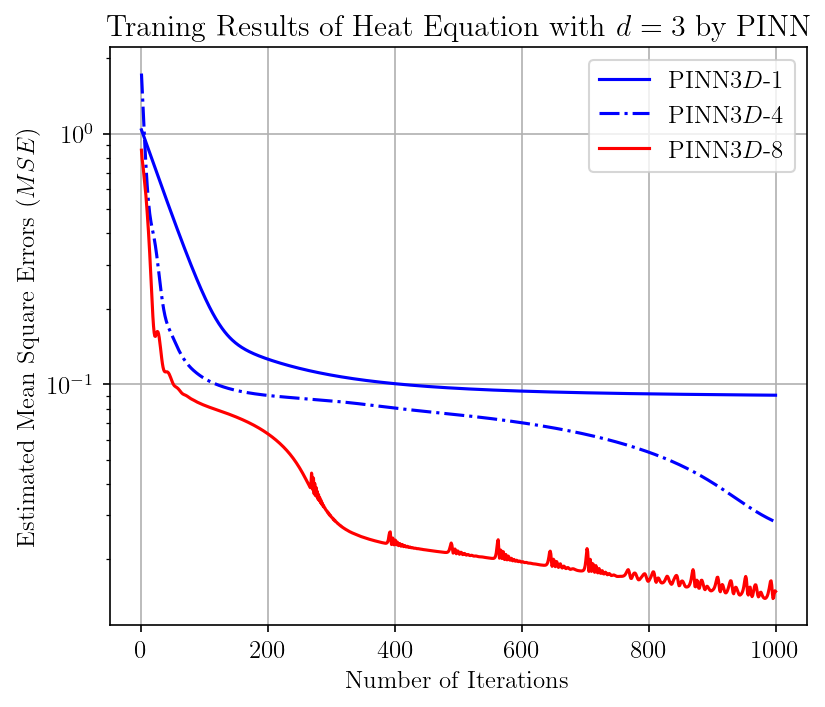

In [256]:
fig = plt.figure(figsize=(6,5), dpi=150)
colors = {1: "b", 4:"b" ,8: "r"}
linestypes = {1:"-", 4: "-.", 8: "-"}
labels = {1: "PINN$3D$-$1$", 
          4:"PINN$3D$-$4$", 
          8:"PINN$3D$-$8$"} 
# xvalues = df[df.columns[0]]

for it in layers:
    # it = df.columns[i]
    plt.semilogy(loss_dict[it], 
             label=labels[it], 
             color=colors[it],
             linestyle=linestypes[it]
            )
# plt.xlim([0,1e3])
plt.ylabel("Estimated Mean Square Errors ($MSE$)")
plt.xlabel("Number of Iterations")
plt.grid()
plt.legend()
plt.title("Traning Results of Heat Equation with $d=3$ by PINN")
plt.savefig("/Users/michaellea/001 - M.Sc_HPC/55640-Project/Seminar-2/Presentation/Slides/F0PINN3D.png", bbox_inches='tight')
plt.show()

In [203]:
file

<_io.TextIOWrapper name='outputs3D1/outputPINN1.dat' mode='a' encoding='UTF-8'>

In [223]:
with open('outputs3D1/outputPINN1.dat', 'a') as file:
    file.write("\n"+np.array2string(S[0,:,0], separator=' ', formatter={'float_kind':lambda x: "%.8f" % x})[1:-1].replace('\n', ''))

In [209]:
(S[0,:,0].shape)

(100,)

In [218]:
np.array2string(S[0,:,0], separator=' ', formatter={'float_kind':lambda x: "%.8f" % x})[1:-1].replace('\n', '')

'-5.20653772 -5.17485046 -5.14301252 -5.11103249 -5.07891369 -5.04666042 -5.01427698 -4.98176861 -4.94913864 -4.91639376 -4.88353777 -4.85057402 -4.81750870 -4.78434563 -4.75109148 -4.71774626 -4.68431997 -4.65081406 -4.61723518 -4.58358574 -4.54987192 -4.51609850 -4.48226929 -4.44838905 -4.41446257 -4.38049412 -4.34649038 -4.31245279 -4.27838755 -4.24429846 -4.21019077 -4.17606926 -4.14193678 -4.10780001 -4.07366085 -4.03952551 -4.00539780 -3.97128153 -3.93718195 -3.90310144 -3.86904597 -3.83501959 -3.80102634 -3.76707053 -3.73315334 -3.69928336 -3.66546178 -3.63169241 -3.59797955 -3.56432819 -3.53074217 -3.49722171 -3.46377492 -3.43040276 -3.39710975 -3.36389899 -3.33077550 -3.29774022 -3.26479912 -3.23195314 -3.19920778 -3.16656470 -3.13402796 -3.10159969 -3.06928444 -3.03708529 -3.00500345 -2.97304392 -2.94120765 -2.90949798 -2.87791920 -2.84647131 -2.81516051 -2.78398633 -2.75295281 -2.72206116 -2.69131541 -2.66071653 -2.63026953 -2.59997249 -2.56983018 -2.53984499 -2.51001883 -2.

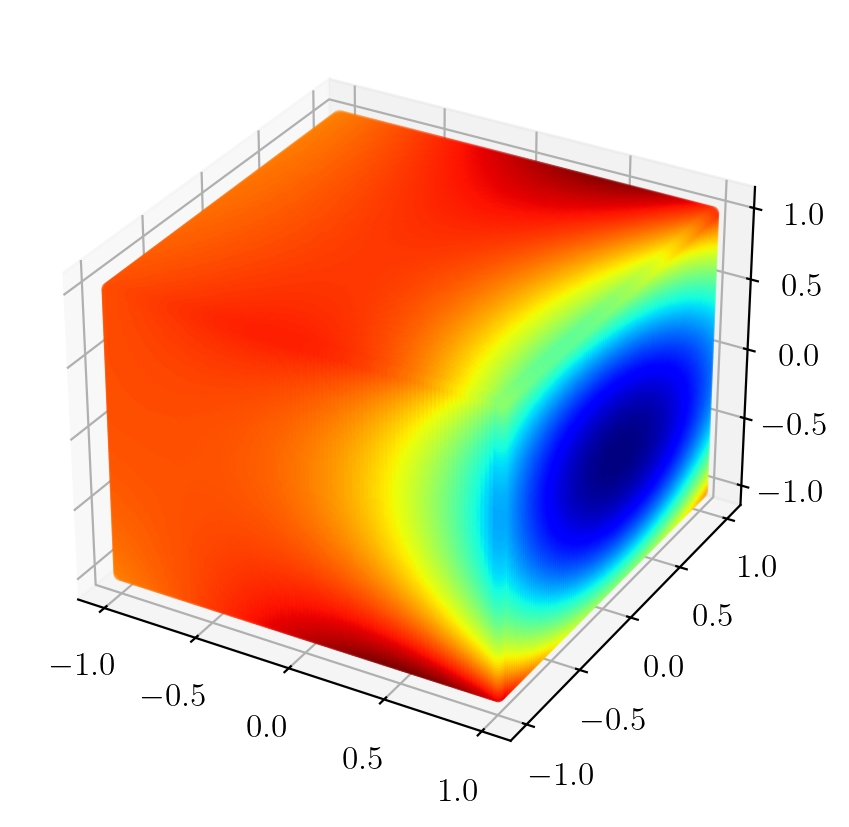

In [191]:
# Create a 3D plots
fig = plt.figure(figsize=(15,5), dpi=200)

#
X = np.linspace(-1, +1, n)
Y = np.linspace(-1, +1, n)
Z = np.linspace(-1, +1, n)
X0, Y0, Z0 = np.meshgrid(X, Y, Z)
X = X0.reshape([n*n*n, 1])
Y = Y0.reshape([n*n*n, 1])
Z = Z0.reshape([n*n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)
Z_T = tf.convert_to_tensor(Z)


ax = fig.add_subplot(121, projection='3d')

S = u(X_T, Y_T, Z_T)
S = S.numpy().reshape(n, n, n)

# scatter = ax.scatter(Grid_World[:,0], Grid_World[:,1], Grid_World[:,2], c=u_ref, cmap='jet', marker='o',alpha=.5, s=2)
ax.scatter(X0, Y0, Z0, c=10.*S, cmap="jet")
# cbar = fig.colorbar(scatter, ax=ax, label='$u(1, x, y)$')
# plt.subplots_adjust(right=0.8)

# # Set labels and title
# ax.set_xlabel('X-axis')
# ax.set_ylabel('Y-axis')
# ax.set_title('Solution')

# plt.xlim([0,1])
# plt.ylim([0,1])

# ax2 = fig.add_subplot(122, projection='3d')
# cbar = fig.colorbar(scatter, ax=ax2, label='$u(1, x, y)$')
# scatter = ax2.scatter(Grid_World[:,0], Grid_World[:,1], Grid_World[:,2], alpha=.5, cmap='jet', marker='o', c = model(Grid_World, training=False),s=2)

# # Set labels and title
# ax2.set_xlabel('X-axis')
# ax2.set_ylabel('Y-axis')
# ax2.set_title('Prediction')

# plt.xlim([0,1])
# plt.ylim([0,1])

# plt.savefig(f"/Users/michaellea/001 - M.Sc_HPC/55640-Project/Seminar-2/Presentation/Slides/F0{d}.png", bbox_inches='tight')

plt.show()